# ABOUT SIIM

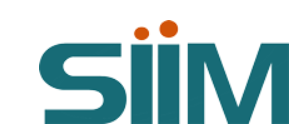

Society for Imaging Informatics in Medicine (SIIM) is the leading healthcare professional organization for those interested in the current and future use of informatics in medical imaging. The society's mission is to advance medical imaging informatics across the enterprise through education, research, and innovation in a multi-disciplinary community.

# ABOUT THE DATA

In this competition, we are identifying and localizing COVID-19 abnormalities on chest radiographs. This is an object detection and classification problem.

A chest radiograph, called a chest X-ray, or chest film, is a projection radiograph of the chest used to diagnose conditions affecting the chest, its contents, and nearby structures. Chest radiographs are the most common film taken in medicine. 

<img align="centre" src="https://post.healthline.com/wp-content/uploads/2020/08/chest-x-ray_thumb-1-732x549.jpg">

## What is opacities in chest X-ray?

On a chest x-ray lung abnormalities will either present as areas of increased density or as areas of decreased density. Lung abnormalities with an increased density - also called opacities - are the most common.

<img align="centre" src="https://prod-images-static.radiopaedia.org/images/130233/8a64788a65af3e40cfcadc3ff9125a_gallery.jpg">

# IMPORTS

Before staring the imports uncomment the below lines and run the for smooth execution of the script.

In [ ]:
#pip install numpy==1.20.1

In [ ]:
#pip install pylibjpeg pylibjpeg-libjpeg pydicom GDCM

All, the necessary imports were made in the below cell.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import ast
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pydicom as dicom
import cv2
%matplotlib inline

# LOAD DATA

Let's first define the input path.

In [ ]:
path = '/kaggle/input/siim-covid19-detection/'

Next, let's read the train_image_level and train_study_level csv in two dataframes.

In [ ]:
image_df = pd.read_csv(path + 'train_image_level.csv')
study_df = pd.read_csv(path + 'train_study_level.csv')

Let's display the first 5 rows of both image_df and study_df.

In [ ]:
image_df.head()

In [ ]:
study_df.head()

# EXPLORATORY DATA ANALYSIS

Next let's display the dataframe info for both the dataframes.

In [ ]:
image_df.info()

The boxes column seems to have null values.

In [ ]:
study_df.info()

There are no columns with null values in the study_df. Next let's display the number records in both the dataframes.

In [ ]:
print(f"Number of records provided in image level csv is {len(image_df)}")
print(f"Number of records provided in study level csv is {len(study_df)}")

From the above results it seems that the image level csv has more rows than study level csv. This indicates chances of duplicates in the image_df. Let's explore this more by finding out the unique values under StudyInstanceUID column of the image_df.

In [ ]:
len(image_df.StudyInstanceUID.unique())

In [ ]:
len(study_df.id.unique())

So, from the above results the unique values in the StudyInstanceUID matches the number of unique values in the id column of the study_df. So, it indicates some of the ids in the image_df has the same StudyInstanceUID. Let's explore this more by finding out the duplicate rows in the image_df.

In [ ]:
dup_df = image_df[image_df.duplicated(['StudyInstanceUID'])==True]
print(f"Number of duplicate rows are {len(dup_df)}")

So, there are 280 duplicate rows. Let's display the dup_df info to see if we can find some more information about the duplicates.

In [ ]:
dup_df.info()

So, from the above results we can see the boxes has only 89 non-null values. The boxes column contains the bounding box information of the annomalies found in the chest xray scans. A null value here kind of hints that the images corresponding to that rows  may not have any conditions of covid pneumonia. 

In [ ]:
dup_df[dup_df.boxes.isnull() == True]['label'].value_counts()

So, it seems all the rows in dup_df which has boxes as null have labels of none type. The images corresponding to those rows don't have any findings and don't have any conditions of covid pneumonia. This proves our assumption was true.

Next let's check if the study_df has any row with 0 in all the columns:- **Negative for Pneumonia, Typical Appearance, Indeterminate Appearance and Atypical Appearance**.

In [ ]:
len(study_df[(study_df.T == 0).all()])

So, from the above results it can be concluded that the study_df doesnot contain the information of the x-ray scans with no findings.

Next let's merge the study_df and image_df by the **StudyInstanceUID** column. For this following steps needs to be performed:-
* The value in the id column of study_df would be split by underscore and we will only keep the part of the value before the underscore.
* The id column in the study_df would next be renamed as StudyInstanceUID.
* Next the two dataframes will be merged by the column StudyInstanceUID.
* Lastly the resultant dataframe will be sorted by StudyInstanceUID.


In [ ]:
study_df['id'] = study_df['id'].str.split('_').apply(lambda x : x[0])
study_df = study_df.rename({'id':'StudyInstanceUID'}, axis=1)
train_df = pd.merge(image_df, study_df, on='StudyInstanceUID') 
train_df = train_df.sort_values(by=['StudyInstanceUID'])
train_df = train_df.reset_index(drop=True)
train_df.head()

Next let's see what more information the column named label under the image_df has to offer. Many of the labels has the word opacity in it. Let's get the count of the word opacity for each record and make a separate column to store the information.

In [ ]:
train_df['Opacity'] = train_df['label'].str.count('opacity')

The dataframe now looks as below.

In [ ]:
train_df.head()

Next let's display the value counts of the opacity column.

In [ ]:
train_df['Opacity'].value_counts()

Next, let's find out the distribution of the findings for each opacity group.

In [ ]:
Opacity_Count = sorted(list(train_df['Opacity'].value_counts().index))
for count in Opacity_Count:
    print('Opacity Count = {}\n------------------------------'.format(count))
    print(train_df[train_df['Opacity'] == count].iloc[:,4:8].sum())
    print(' ')

Next let's make visualization of the above information.

In [ ]:
for count in Opacity_Count:
    Count_Series = train_df[train_df['Opacity'] == count].iloc[:,4:8].sum()
    fig = plt.figure(figsize=(12,3))
    sns.barplot(x=Count_Series.index, y=Count_Series.values/sum(train_df['Opacity']==count))
    plt.title('OpacityCount : {} '.format(count))
    plt.plot();

From the above results it can be concluded that other than opacity 0 none of the other opacity classes have samples belonging to **Negative for Pneumonia**.

Next let's display some images of each category of findings. For this we will write a function which can extract the bounding boxes of the images from the boxes column of the train_df and draw boxes on the image. The colors used to draw the bounding box for each category is given below:-

* 'r' ---> Negative for Pneumonia
* 'b' ---> Typical Appearance
* 'g' ---> Indeterminate Appearance
* 'y' ---> Atypical Appearance

In [ ]:
def display_image(image_name, image_id, bounding_box, palet):
    image_path = path + 'train/' + image_name
    img_id = image_id.replace('_image','.dcm')
    for (dirpath, dirnames,filenames) in os.walk(image_path):
        if os.path.exists(dirpath+'/'+img_id) == True:
            data_file = dicom.dcmread(dirpath+'/'+img_id)
            img = data_file.pixel_array
            fig, ax = plt.subplots(1,1, figsize=(8,4))
            if pd.isnull(bounding_box) == False:
                boxes = ast.literal_eval(bounding_box)
                for box in boxes:
                    p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                                      box['width'], box['height'],
                                                      ec=palet, fc='none', lw=1.5)
                    ax.add_patch(p)
            ax.set_title(image_id) 
            ax.imshow(img, cmap='gray')
            plt.show()

Before using this function to display some images, let's check if whether the images which are Negative for Pneumonia have bounding boxes.

In [ ]:
len(train_df[(train_df['Negative for Pneumonia']==1) & (train_df['boxes'].isnull() == False)])

So, it seems the images which are marked as Negative for Pneumonia don't have bounding boxes. Now, let's see some images which were diagonosed with Negative for Pneumonia.

Next let's try to find out how many duplicated StudyInstanceUID rows classified as Typical Appearance has more than one findings with positive for Typical Appearance.

In [ ]:
temp_df  = train_df[(train_df['Typical Appearance']==1) & 
         (train_df.duplicated(['StudyInstanceUID'], keep=False))].sort_values(by=['StudyInstanceUID'])
ser1 = temp_df['StudyInstanceUID'].value_counts()
num_records = 0
for idx in ser1.index:
    count = len(temp_df[(temp_df['StudyInstanceUID'] == idx) & (temp_df['boxes'].isnull() == False)])
    if count > 1:
        num_records = num_records + 1
print(f"Number of Study instances with more than one image classified as Typical Appearance is {num_records}.")
        

So, from the above result it can be concluded that even in rows with duplicated StudyInstanceUID there is only one image which was classified as Typical Appearance and that drove the decision behind classifying that study as Typical Appearance.

Let's try to do the same test for Indeterminate Appearance.

In [ ]:
temp_df  = train_df[(train_df['Indeterminate Appearance']==1) & 
         (train_df.duplicated(['StudyInstanceUID'], keep=False))].sort_values(by=['StudyInstanceUID'])
ser1 = temp_df['StudyInstanceUID'].value_counts()
num_records = 0
for idx in ser1.index:
    count = len(temp_df[(temp_df['StudyInstanceUID'] == idx) & (temp_df['boxes'].isnull() == False)])
    if count > 1:
        num_records = num_records + 1
print(f"Number of Study instances with more than one image classified as Indeterminate Appearance is {num_records}.")
        

So, from the above result it can be concluded that even in rows with duplicated StudyInstanceUID there is only one image which was classified as Indeterminate Appearance and that drove the decision behind classifying that study as Indeterminate Appearance.

Next, let's try the same test for  Atypical Appearance.

In [ ]:
temp_df  = train_df[(train_df['Atypical Appearance']==1) & 
         (train_df.duplicated(['StudyInstanceUID'], keep=False))].sort_values(by=['StudyInstanceUID'])
ser1 = temp_df['StudyInstanceUID'].value_counts()
num_records = 0
for idx in ser1.index:
    count = len(temp_df[(temp_df['StudyInstanceUID'] == idx) & (temp_df['boxes'].isnull() == False)])
    if count > 1:
        num_records = num_records + 1
print(f"Number of Study instances with more than one image classified as Atypical Appearance is {num_records}.")

So, from the above result it can be concluded that even in rows with duplicated StudyInstanceUID there is only one image which was classified as Atypical Appearance and that drove the decision behind classifying that study as Atypical Appearance.

In [ ]:
temp_df = train_df[(train_df['Negative for Pneumonia']==1)].sample(n=5)
ids = temp_df.id.to_list()
names = temp_df.StudyInstanceUID.to_list()
boxes = temp_df.boxes.to_list()
palet = 'r'
for image_name, image_id, box in zip(names, ids, boxes):
    display_image(image_name, image_id, box, palet)

Next, lets look at some images which had Typical Appearance.

In [ ]:
temp_df = train_df[(train_df['Typical Appearance']==1) & (train_df['boxes'].isnull()==False)].sample(n=5)
ids = temp_df.id.to_list()
names = temp_df.StudyInstanceUID.to_list()
boxes = temp_df.boxes.to_list()
palet = 'b'
for image_name, image_id, box in zip(names, ids, boxes):
    display_image(image_name, image_id, box, palet)

Next, let's look at some images with Indeterminate Appearance.

In [ ]:
temp_df = train_df[(train_df['Indeterminate Appearance']==1) & (train_df['boxes'].isnull()==False)].sample(n=5)
ids = temp_df.id.to_list()
names = temp_df.StudyInstanceUID.to_list()
boxes = temp_df.boxes.to_list()
palet = 'g'
for image_name, image_id, box in zip(names, ids, boxes):
    display_image(image_name, image_id, box, palet)

Next, display the images which had Atypical Appearance.

In [ ]:
temp_df = train_df[(train_df['Atypical Appearance']==1) & (train_df['boxes'].isnull()==False)].sample(n=5)
ids = temp_df.id.to_list()
names = temp_df.StudyInstanceUID.to_list()
boxes = temp_df.boxes.to_list()
palet = 'y'
for image_name, image_id, box in zip(names, ids, boxes):
    display_image(image_name, image_id, box, palet)

# CONCLUSION

From the above analysis following points can be concluded:-

* **If, a study don't have opacity count 0 then it doesn't get classified as Negative for Pneumonia. In other words opacity count higher that 0 tells that the study has some conditions for pneumonia.**
* **A study can have more than one image but it can be classified for a condition of pneumonia if it has atleast one image which has been clasified for that condition for pneumonia.**
* **If no images in a study has bounding box then it is classified as Negative for Pneumonia.**